# Processing scripts for generating figures for Dafne paper

## Processing log file

In [2]:
import os
from typing import Iterable
import re

DELETE_NONANON_FILES = False

def find_elements_pattern(string_list: Iterable[str], pattern: str):
    return [ s for s in string_list if re.match(pattern, s) is not None]

### Anonymization

In [3]:
def anonymize_line(line: str):
    pattern = 'accessed by \S+'
    rep = 'accessed by XXXXXXX'
    line = re.sub(pattern, rep, line)
    pattern2 = 'Log message from \S+'
    rep2 = 'Log message from XXXXXXX'
    line = re.sub(pattern2, rep2, line)
    pattern3 = r'([0-9]+)_\S+.model'
    rep3 = r'\1_XXXXXXX.model'
    line = re.sub(pattern3, rep3, line)
    return line
    

def anonymize_file(filename: str):
    out_filename = filename[:-3] + 'anon.txt'
    with open(filename, 'r') as input_file:
        with open(out_filename, 'w') as output_file:
            for line in input_file:
                output_file.write(anonymize_line(line))

files = os.listdir()
nonanon_log_files = find_elements_pattern(files, 'log.*(?<!anon)\.txt')
for file in nonanon_log_files:
    anonymize_file(file)
    if DELETE_NONANON_FILES:
        os.unlink(file)
    print('Anonymized', file)


Anonymized log_20220831_orig.txt


### Read in anonymized file

In [4]:
import os
from dateutil.parser import parse
import pandas as pd

files = os.listdir()
anon_log_files = find_elements_pattern(files, 'log.*anon\.txt')
anon_log_file = anon_log_files[0]
print('Reading from', anon_log_file)

def split_log_line(line: str):
    date_part = line[:27]
    text_part = line[27:].strip()
    date = parse(date_part)
    return (date, text_part)

with open(anon_log_file,'r') as f:
    log_lines = [ split_log_line(line) for line in f ]
    
log_frame = pd.DataFrame(log_lines, columns = ['DateTime', 'Message'])
log_frame = log_frame.set_index('DateTime')


Reading from log_20220831_orig.anon.txt


### Filter dates and messages

In [5]:
from datetime import datetime

date_start = datetime(2021,7,1)

sub_frame = log_frame.loc[date_start:]

In [6]:
# Extract dice scores

def extract_dice(line):
    m = re.search('client dice ([0-9.]+)', line)
    if not m: return None
    return float(m.group(1))

dice_messages_mask = sub_frame['Message'].str.contains('client dice')
dice_messages_frame = sub_frame[dice_messages_mask]
dice_scores = dice_messages_frame['Message'].apply(extract_dice)
dice_scores = dice_scores[dice_scores > 0]
dice_scores.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 256 entries, 2021-07-05 08:43:32.036859 to 2022-08-30 14:34:38.191543
Series name: Message
Non-Null Count  Dtype  
--------------  -----  
256 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


np.percentile(dice_scores_notime,0)=0.00011810256477525792
np.percentile(dice_scores_notime,25)=0.6794755932451608
np.percentile(dice_scores_notime,50)=0.8033749230536169
np.percentile(dice_scores_notime,75)=0.8869511933148697
np.percentile(dice_scores_notime,100)=0.9999999995861314


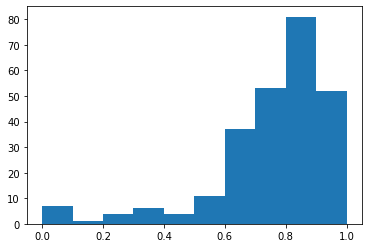

In [7]:
import matplotlib.pyplot as plt
import numpy as np
dice_scores_notime = np.array(list(dice_scores))
plt.hist(dice_scores_notime)
print(f'{np.percentile(dice_scores_notime,0)=}')
print(f'{np.percentile(dice_scores_notime,25)=}')
print(f'{np.percentile(dice_scores_notime,50)=}')
print(f'{np.percentile(dice_scores_notime,75)=}')
print(f'{np.percentile(dice_scores_notime,100)=}')

# Processing the validation data

The validation data are anonymized data extracted from the local PACS. They were segmented using Dafne and manually refined.
The testing on the various model versions was made using the command (included in Dafne):
```
python /home/francesco/work/workspace/dafne/batch_validate.py --roi <roi_file.p> .
```

## Loading data

In [8]:
import os, glob, csv
import pandas as pd

#this is the model right before the validation training
training_beginning_model = 1635419523
training_end_model = 1636967897


def load_data_subdirs(base_path):
    subdirs = os.listdir(base_path)
    data_list = []
    for d in subdirs:
        current_subdir = os.path.join(base_path, d)
        txt_file_list = glob.glob(os.path.join(current_subdir, '*.txt'))
        if not txt_file_list:
            continue
        txt_file = txt_file_list[0]
        data_frame = pd.read_csv(txt_file, names=['model_id', 'dice'])
        #data_frame = data_frame.assign(name=d)
        data_frame.insert(0, 'name', d, True)
        #print(data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        data_frame.insert(2, 'relative_dice', data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        data_list.append(data_frame)
    data_out = pd.concat(data_list)
    return data_out
        
                             
dice_scores_training = load_data_subdirs('validation_results/validation_training')
dice_scores_final_validation = load_data_subdirs('validation_results/final_validation')
dice_scores_training = dice_scores_training[training_beginning_model <= dice_scores_training['model_id']]
dice_scores_training = dice_scores_training[dice_scores_training['model_id'] <= training_end_model]
dice_scores_final_validation = dice_scores_final_validation[training_beginning_model <= dice_scores_final_validation['model_id']]
dice_scores_final_validation = dice_scores_final_validation[dice_scores_final_validation['model_id']  <= training_end_model]

In [9]:
import matplotlib.pyplot as plt

def groupby_to_numpy(pd_groupby):
    data_list = []
    for name, group in pd_groupby:
        data_list.append(np.array(group))
    return np.stack(data_list).T

def plot_data(data_frame):
    relative_dice_data = data_frame.groupby('name')['relative_dice']
    relative_dice_data = groupby_to_numpy(relative_dice_data)
    relative_dice_mean = np.array(data_frame.groupby('model_id').mean()['relative_dice'])
    plt.plot(relative_dice_data, linewidth=0.8)
    plt.plot(relative_dice_mean, 'r', linewidth=4)

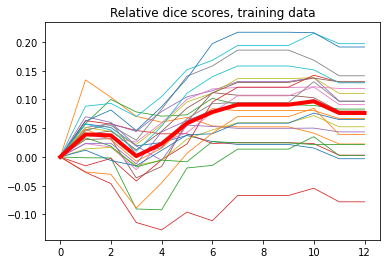

In [10]:
plot_data(dice_scores_training)
plt.title('Relative dice scores, training data')
plt.savefig('relative_dice_training.svg')

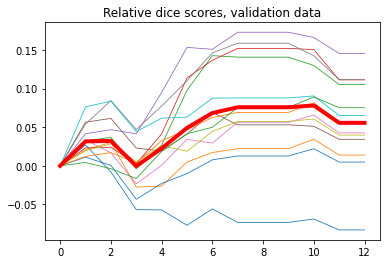

In [11]:
plot_data(dice_scores_final_validation)
plt.title('Relative dice scores, validation data')
plt.savefig('relative_dice_validation.svg')

## Statistical evaluation
We use a linear model on the relative dice score change.

In [12]:
dice_scores_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 96 to 108
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           325 non-null    object 
 1   model_id       325 non-null    int64  
 2   relative_dice  325 non-null    float64
 3   dice           325 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 12.7+ KB


In [45]:
data_frame = dice_scores_training
relative_dice_data = groupby_to_numpy(data_frame.groupby('name')['relative_dice'])
obs = relative_dice_data.T.ravel()
x = np.tile(np.arange(relative_dice_data.shape[0]),relative_dice_data.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        0,  1,  2,  3,  4

In [50]:
import statsmodels.api as sm

def fit_lm(data_frame):
    relative_dice_data = groupby_to_numpy(data_frame.groupby('name')['relative_dice'])
    obs = relative_dice_data.T.ravel()
    x = np.tile(np.arange(relative_dice_data.shape[0]),relative_dice_data.shape[1])
    model = sm.OLS(obs, x).fit()
    return model

In [51]:
model_training = fit_lm(dice_scores_training)
model_training.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.549
Method:                 Least Squares   F-statistic:                              397.2
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                    2.98e-58
Time:                        12:44:03   Log-Likelihood:                          465.38
No. Observations:                 325   AIC:                                     -928.8
Df Residuals:                     324   BIC:                                     -925.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0090      0.000     19.931      0.000       0.008       0.010
==============================================================================
Omnibus:                       13.745   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.131
Skew:                          -0.373   Prob(JB):                     0.000191
Kurtosis:                       3.841   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model_validation = fit_lm(dice_scores_final_validation)
model_validation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              147.4
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                    9.32e-25
Time:                        12:44:39   Log-Likelihood:                          250.80
No. Observations:                 169   AIC:                                     -499.6
Df Residuals:                     168   BIC:                                     -496.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0073      0.001     12.142      0.000       0.006       0.008
==============================================================================
Omnibus:                        7.334   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.150
Skew:                          -0.345   Prob(JB):                       0.0170
Kurtosis:                       3.825   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""